In [1]:
import os 
import pdb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
class KNN:
    def __init__(self, k=5):
        self.k = k

    def fit(self, X, y, code):
        self.X_train = X
        self.y_train = y
        self.code_name = code

    def predict(self, X):
        dists = torch.cdist(X, self.X_train)  # Compute Euclidean distances
        print('here')
        print(dists.shape)
        print(dists[:100])
        _, indices = dists.topk(self.k, largest=False, dim=1)  # Get k smallest distances' indices
        k_nearest_labels = self.y_train[indices]  # Get labels of k nearest neighbors
        code = []
        for l1 in k_nearest_labels:
            #print("l1")
            tmp = []
            for l2 in l1:
                #print("l2")
                for l3 in l2:
                    #print("l3")
                    #print(l3)
                    tmp.append(f"{str(int(l3.item())):>06}")
            code.append(tmp)
        print(len(code))
        result = [self.code_name[self.code_name["종목코드"].isin(elem)]["종목명"] for elem in code]
        #k_nearest_labels = self.code_name[self.code_name["종목코드"]==self.y_train[indices]]["종목명"]
        #predicted_labels = torch.mode(k_nearest_labels, dim=1).values  # Predict most common label
        return result, k_nearest_labels, indices
    

def recommend(user_inform):
    global base_path
    #model_path = "/".join(base_path[:-2]+["Recommendation", "knn_model.pth"])
    path = "../../data/cs_mkt_dataset/cs_data.csv"
    # Create k-NN classifier
    print("Constructing k-NN classifier ...")
    knn = KNN(k=5)
      
    #if not os.path.exists(model_path):
    print("Loading CustomerData  ...")
    data = pd.read_csv(path)

    print("Processing Nan value  ...")
    data = data.fillna(method='ffill')
    data = data.fillna(method="bfill")
    data.isnull().sum()

    # column data type 변경
    # 우선은 M1만으로 추천시스템 구축
    print("Constructing Data  ...")
    #print(f'{data[["CASH_AST_M1","DMST_AST_EVAL_M1","DMST_AST_PCHS_M1"]].values.dtype}')
    #print(f'{data[["DMST_AST1_ITM_M1"]].values.dtype}')
    data.loc[data["DMST_AST1_ITM_M1"]=="*"] = 0
    data[["DMST_AST1_ITM_M1"]] = data[["DMST_AST1_ITM_M1"]].astype(dtype='float64')
    #print(f'{data[["DMST_AST1_ITM_M1"]].values.dtype}')
    dm_trainX = torch.tensor(data[["CASH_AST_M1","DMST_AST_EVAL_M1","DMST_AST_PCHS_M1"]].values)
    dm_trainY = torch.tensor(data[["DMST_AST1_ITM_M1"]].values)

    # Create a 3D scatter plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data["CASH_AST_M1"], data["DMST_AST_EVAL_M1"], data["DMST_AST_PCHS_M1"], c='blue', marker='o', label='Data Points')

    # Customize the plot
    ax.set_title('3D Scatter Plot')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.legend()

    # Show the plot
    plt.show()

    print("Loading Stock Code Information ...")
    path = "../../data/cs_mkt_dataset/code.csv"
    path = "/".join(base_path[:-3]+["data","cs_mkt_dataset","code.csv"])
    code_inform = pd.read_csv(path, encoding='cp949')
    
    knn.fit(dm_trainX.float(), dm_trainY.float(), code_inform)

    # Save model to a .pth file
    #torch.save(knn, model_path)

    print("Loading Customer data who want to get recommendation ...")
    # X_test에 고객 정보가 있어야 함.
    # 지금 버전에서는 M1분기의 현금보유액, 매입주식평가액, 주식 매입액: 총 3개의 data필요.
    X_test = torch.tensor([[10000000.0,23000000.0,49000000.0]]).float()

    # Load model from the .pth file
    #loaded_knn = torch.load(model_path)

    # Predict labels for test data using loaded model
    code_name, predicted_labels = knn.predict(X_test)
    #print("Predicted labels using loaded model:", predicted_labels)
    #print("Predicted code_name using loaded model:\n", code_name)
    #pdb.set_trace()
    code_name = code_name[0].values
    answer = f"The stocks that are right for you are as follows: Stocks: {', '.join(code_name)}"
    return answer

In [3]:
path = "../../data/cs_mkt_dataset/cs_data.csv"

    
#if not os.path.exists(model_path):
print("Loading CustomerData  ...")
data = pd.read_csv(path)

Loading CustomerData  ...


/tmp/ipykernel_94142/3438175210.py:6: DtypeWarning: Columns (31,32,33,62,63,64,93,94,95,124,125,126,221,389) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path)


In [4]:
print("Processing Nan value  ...")
fill_na = data.copy(deep=True)
drop_na = data.copy(deep=True)
fill_na = fill_na.fillna(method='ffill')
fill_na = fill_na.fillna(method="bfill")
drop_na = drop_na.dropna()

print(fill_na.shape)
print(drop_na.shape)
# column data type 변경
# 우선은 M1만으로 추천시스템 구축
print("Constructing Data  ...")
#print(f'{data[["CASH_AST_M1","DMST_AST_EVAL_M1","DMST_AST_PCHS_M1"]].values.dtype}')
#print(f'{data[["DMST_AST1_ITM_M1"]].values.dtype}')
fill_na.loc[fill_na["DMST_AST1_ITM_M1"]=="*"] = 0
fill_na[["DMST_AST1_ITM_M1"]] = fill_na[["DMST_AST1_ITM_M1"]].astype(dtype='float64')
#print(f'{data[["DMST_AST1_ITM_M1"]].values.dtype}')
dm_trainX = torch.tensor(fill_na[["CASH_AST_M1","DMST_AST_EVAL_M1","DMST_AST_PCHS_M1"]].values)
dm_trainY = torch.tensor(fill_na[["DMST_AST1_ITM_M1"]].values)

Processing Nan value  ...
(803308, 520)
(5, 520)
Constructing Data  ...


In [5]:
"""
X = selected_rows[["CASH_AST_M1","DMST_AST_EVAL_M1","DMST_AST_PCHS_M1"]]  # High-dimensional data
#X = selected_rows
y = selected_rows[["DMST_AST1_ITM_M1"]] # Target labels

# Perform PCA for dimensionality reduction to 2D and 3D
#pca_2d = PCA(n_components=2)
#pca_3d = PCA(n_components=3)
#X_pca_2d = pca_2d.fit_transform(X)
#X_pca_3d = pca_3d.fit_transform(X)

# Perform t-SNE for nonlinear dimensionality reduction to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=40)
X_tsne = tsne.fit_transform(X)
#print(X_tsne)

# Create 2D and 3D plots
plt.figure(figsize=(12, 6))

# Plot PCA 2D
plt.subplot(121)
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y, cmap='viridis')
plt.title('PCA 2D')

# Plot PCA 3D
ax = plt.subplot(122, projection='3d')
ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=y, cmap='viridis')
plt.title('PCA 3D')

plt.tight_layout()
plt.show()

# Plot t-SNE 2D
plt.figure(figsize=(8, 6))
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c='green')

plt.title('t-SNE 2D')
plt.show()
"""


NameError: name 'selected_rows' is not defined

In [6]:
# Create k-NN classifier
print("Constructing k-NN classifier ...")
knn = KNN(k=5)

print("Loading Stock Code Information ...")
path = "../../data/cs_mkt_dataset/code.csv"
code_inform = pd.read_csv(path, encoding='cp949')

knn.fit(dm_trainX.float(), dm_trainY.float(), code_inform)

# Save model to a .pth file
#torch.save(knn, model_path)

print("Loading Customer data who want to get recommendation ...")
# X_test에 고객 정보가 있어야 함.
# 지금 버전에서는 M1분기의 현금보유액, 매입주식평가액, 주식 매입액: 총 3개의 data필요.
X_test = torch.tensor([[100000000,10000,1000000000]]).float()
#X_test = torch.tensor([[1000000,10000,1000000]]).float()

# Load model from the .pth file
#loaded_knn = torch.load(model_path)

# Predict labels for test data using loaded model
code_name, predicted_labels, indices = knn.predict(X_test)
#print("Predicted labels using loaded model:", predicted_labels)
#print("Predicted code_name using loaded model:\n", code_name)
#pdb.set_trace()
code_name = code_name[0].values
answer = f"The stocks that are right for you are as follows: Stocks: {', '.join(code_name)}"

Constructing k-NN classifier ...
Loading Stock Code Information ...
Loading Customer data who want to get recommendation ...
here
torch.Size([1, 803308])
tensor([[9.9537e+08, 9.0887e+08, 9.5368e+08,  ..., 9.2944e+08, 8.4930e+08,
         9.7336e+08]])
1


In [ ]:
for index in indices[0]:
    print(index.item())

330135
723287
502786
648020
759176


In [ ]:
fill_na.loc[684781]["CASH_AST_M1"]

2100000.0

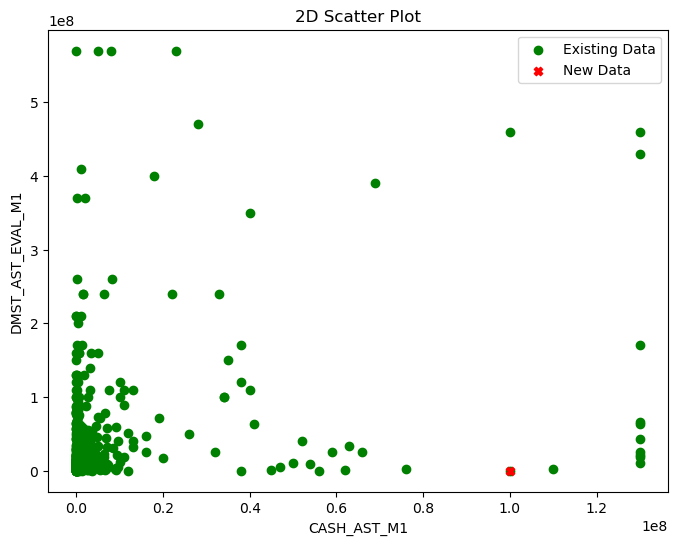

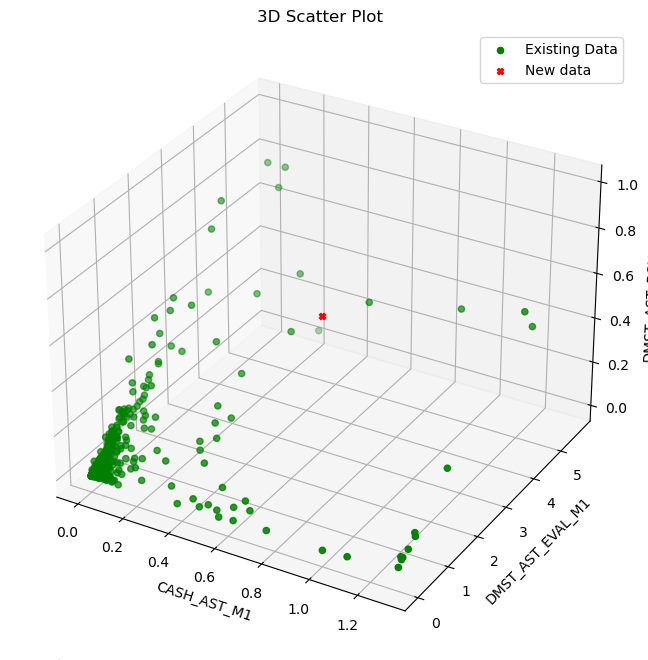

In [7]:
#data = load_iris()
num_rows_to_select = 500  # Adjust this value as needed

# Randomly select rows
selected_rows = fill_na.sample(n=num_rows_to_select, random_state=42)  # Set a random_state for reproducibility

# Sample data
x = selected_rows["CASH_AST_M1"]
y = selected_rows["DMST_AST_EVAL_M1"]
#newdata = selected_rows.sample(n=5)
newdata=pd.DataFrame({"CASH_AST_M1":np.array([100000000]),
                      "DMST_AST_EVAL_M1":np.array([10000]),
                      "DMST_AST_PCHS_M1":np.array([1000000000])})

# Create a 2D scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='green', marker='o', label='Existing Data')
plt.scatter(newdata["CASH_AST_M1"], newdata["DMST_AST_EVAL_M1"], c='red', marker='X', label='New Data')
#for index in indices[0]:
#    plt.scatter(fill_na.loc[[index.item()]][["CASH_AST_M1"]], fill_na.loc[[index.item()]][["DMST_AST_EVAL_M1"]],c='m', marker="*", label='Neighbor')

# Customize the plot
plt.title('2D Scatter Plot')
plt.xlabel('CASH_AST_M1')
plt.ylabel('DMST_AST_EVAL_M1')
plt.legend()

# Show the plot
plt.show()

# New Data


# Create a 3D scatter plot
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(selected_rows["CASH_AST_M1"], selected_rows["DMST_AST_EVAL_M1"], selected_rows["DMST_AST_PCHS_M1"], c='green', marker='o', label='Existing Data')
ax.scatter(newdata["CASH_AST_M1"], newdata["DMST_AST_EVAL_M1"], newdata["DMST_AST_PCHS_M1"], c='red', marker='X', label='New data')
#for index in indices[0]:
#    ax.scatter(fill_na.loc[index.item()]["CASH_AST_M1"],\
#                fill_na.loc[index.item()]["DMST_AST_EVAL_M1"],\
#                    fill_na.loc[index.item()]["DMST_AST_PCHS_M1"],c='m', marker="*", label='Neighbor')

# Customize the plot
ax.set_title('3D Scatter Plot')
ax.set_xlabel('CASH_AST_M1')
ax.set_ylabel('DMST_AST_EVAL_M1')
ax.set_zlabel('DMST_AST_PCHS_M1')
ax.legend()

# Show the plot
plt.show()